<a href="https://colab.research.google.com/github/jamartinezv2023/deeplearning/blob/main/03_arquitectura_de_linea_de_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notebook 03 – Arquitectura Base (CNN Robustecida)

#1. Montaje y Librerías

In [1]:
# ==============================
# 1. Montaje de Drive y librerías
# ==============================
import os, glob
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#2. Búsqueda Automática de los .npy

In [2]:
# ==============================
# 2. Función para buscar .npy en TODO el Drive
# ==============================
def find_npy(filename, base_dir="/content/drive/MyDrive"):
    matches = glob.glob(os.path.join(base_dir, "**", filename), recursive=True)
    if not matches:
        raise FileNotFoundError(f"No se encontró {filename} en {base_dir}")
    return matches[0]

X_seq_path = find_npy("X_seq.npy")
X_static_path = find_npy("X_static.npy")
y_path = find_npy("y.npy")

print("Archivos encontrados:")
print("X_seq:", X_seq_path)
print("X_static:", X_static_path)
print("y:", y_path)


Archivos encontrados:
X_seq: /content/drive/MyDrive/football/artifacts/X_seq.npy
X_static: /content/drive/MyDrive/football/artifacts/X_static.npy
y: /content/drive/MyDrive/football/artifacts/y.npy


#3. Cargar Datos

In [3]:
# ==============================
# 3. Cargar arrays procesados
# ==============================
X_seq = np.load(X_seq_path)        # (muestras, seq_len, 1)
X_static = np.load(X_static_path)  # (muestras, n_features)
y = np.load(y_path)                # (muestras,)

print("Shapes:")
print("X_seq:", X_seq.shape)
print("X_static:", X_static.shape)
print("y:", y.shape)


Shapes:
X_seq: (48532, 5, 1)
X_static: (48532, 3)
y: (48532,)


#4. Dividir en Train/Test

In [4]:
# ==============================
# 4. Train/test split
# ==============================
from sklearn.model_selection import train_test_split

X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.2, random_state=42
)

print("Train seq:", X_seq_train.shape, "Test seq:", X_seq_test.shape)
print("Train static:", X_static_train.shape, "Test static:", X_static_test.shape)


Train seq: (38825, 5, 1) Test seq: (9707, 5, 1)
Train static: (38825, 3) Test static: (9707, 3)


#5. Arquitectura CNN + Dense

In [5]:
# ==============================
# 5. Definir modelo CNN + Dense
# ==============================
seq_len = X_seq.shape[1]
n_features = X_static.shape[1]
n_classes = len(np.unique(y))

# Input secuencial (ej: tiempo o jugadas)
seq_input = keras.Input(shape=(seq_len, 1), name="sequential_input")
x = layers.Conv1D(32, kernel_size=3, activation="relu", padding="same")(seq_input)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Flatten()(x)

# Input estático (ej: características fijas)
static_input = keras.Input(shape=(n_features,), name="static_input")

# Combinar ambos
combined = layers.concatenate([x, static_input])
z = layers.Dense(64, activation="relu")(combined)
output = layers.Dense(n_classes, activation="softmax")(z)

model = keras.Model(inputs=[seq_input, static_input], outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequential_input    │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 32)     │        128 │ sequential_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 2, 32)     │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 2, 64)     │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 131)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,979 (58.51 KB)

 Trainable params: 14,979 (58.51 KB)

 Non-trainable params: 0 (0.00 B)

#6. Compilación y Callbacks

In [6]:
# ==============================
# 6. Compilar modelo y callbacks
# ==============================
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

# Callbacks para reproducibilidad
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ModelCheckpoint(
        "/content/drive/MyDrive/football_project/models/cnn_base.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


#7. Entrenamiento

In [7]:
# ==============================
# 7. Entrenar modelo
# ==============================
history = model.fit(
    {"sequential_input": X_seq_train, "static_input": X_static_train},
    y_train,
    validation_data=(
        {"sequential_input": X_seq_test, "static_input": X_static_test}, y_test
    ),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)


Epoch 1/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4851 - loss: 1.0505 - val_accuracy: 0.4780 - val_loss: 1.0487
Epoch 2/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4870 - loss: 1.0425 - val_accuracy: 0.4793 - val_loss: 1.0477
Epoch 3/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4942 - loss: 1.0383 - val_accuracy: 0.4782 - val_loss: 1.0476
Epoch 4/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4970 - loss: 1.0362 - val_accuracy: 0.4785 - val_loss: 1.0472
Epoch 5/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4893 - loss: 1.0392 - val_accuracy: 0.4790 - val_loss: 1.0488
Epoch 6/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4925 - loss: 1.0379 - val_accuracy: 0.4784 - val_loss: 1.0480
Epoch 7/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4867 - loss: 1.0403 - val_accuracy: 0.4794 - val_loss: 1.0475
Epoch 8/50
1214/1214 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.4950 - loss: 1.0344 - 

#8. Evaluación

In [8]:
# ==============================
# 8. Evaluación final
# ==============================
loss, acc = model.evaluate(
    {"sequential_input": X_seq_test, "static_input": X_static_test}, y_test
)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4867 - loss: 1.0412
Test Loss: 1.0472
Test Accuracy: 0.4785


#9. Curvas de Entrenamiento

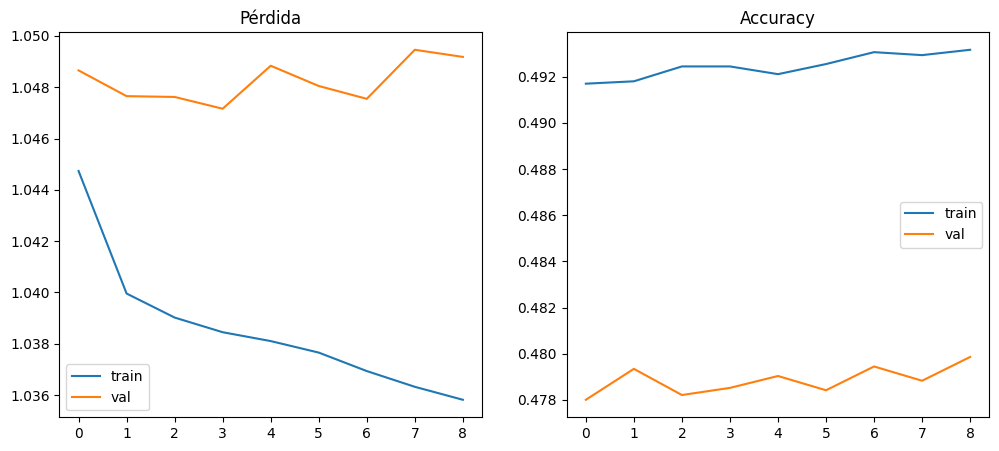

In [9]:
# ==============================
# 9. Gráficas de pérdida y accuracy
# ==============================
plt.figure(figsize=(12,5))

# Pérdida
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Pérdida")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.show()


#10. Guardado final del modelo (formato moderno)

In [10]:
# ==============================
# 10. Guardar modelo en formato moderno (.keras)
# ==============================
save_path = "/content/drive/MyDrive/football_project/models/cnn_base_final.keras"
model.save(save_path)
print("✅ Modelo guardado en:", save_path)


✅ Modelo guardado en: /content/drive/MyDrive/football_project/models/cnn_base_final.keras


#README.md (para carpeta 03/)

# Notebook 03 - Arquitectura Base (CNN robusta)

Este notebook implementa una CNN simple con datos secuenciales (`X_seq.npy`) y estáticos (`X_static.npy`) generados en el **Notebook 02 - Preprocesado**.  
El objetivo es entrenar un modelo de línea base y guardar el resultado en formato moderno `.keras`.

## Pasos principales:
1. Montaje de Google Drive.
2. Búsqueda automática de los arrays `.npy` en todo el Drive.
3. División en train/test.
4. Definición de modelo CNN + capas densas.
5. Entrenamiento con callbacks (`EarlyStopping`, `ModelCheckpoint`).
6. Evaluación y gráficas.
7. Guardado reproducible del modelo en `models/cnn_base_final.keras`.

## Requisitos previos
- Haber ejecutado `02-preprocesado.ipynb` para generar los `.npy`.
- Librerías: `numpy`, `matplotlib`, `tensorflow`, `scikit-learn`.

## Salidas
- Modelo entrenado guardado en:  
